In [ ]:
import pandas as pd

# Load the CSV files
combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path)

senior_bowl_data = senior_bowl_data.dropna(subset=["athlete_id"])

merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

columns_to_compare = ["Height (in)", "Weight (lbs)", "Hand Size (in)", "Arm Length (in)"]

player_discrepancies = {}

for _, row in merged_data.iterrows():
    athlete_id = row["athlete_id"]
    name = row["Name"]
    discrepancies = []
    
    for column in columns_to_compare:
        combine_col = f"{column}_combine"
        senior_bowl_col = f"{column}_senior_bowl"
        
        combine_value = row[combine_col]
        senior_bowl_value = row[senior_bowl_col]
        
        if combine_value != 0 and senior_bowl_value != 0: 
            percent_diff = (abs(combine_value - senior_bowl_value) / ((combine_value + senior_bowl_value) / 2)) * 100
            discrepancies.append({
                "column": column,
                "combine_value": combine_value,
                "senior_bowl_value": senior_bowl_value,
                "percent_diff": percent_diff
            })
    
    discrepancies_sorted = sorted(discrepancies, key=lambda x: x["percent_diff"], reverse=True)
    
    player_discrepancies[name] = discrepancies_sorted[:5]

for player, discrepancies in player_discrepancies.items():
    print(f"Player: {player}")
    for discrepancy in discrepancies:
        print(f"  Column: {discrepancy['column']}, "
              f"Combine Value: {discrepancy['combine_value']}, "
              f"Senior Bowl Value: {discrepancy['senior_bowl_value']}, "
              f"Percentage Difference: {discrepancy['percent_diff']:.2f}%")
    print("-" * 50)

Player: Jaxson Dart
  Column: Weight (lbs), Combine Value: 223.0, Senior Bowl Value: 226, Percentage Difference: 1.34%
  Column: Arm Length (in), Combine Value: 30.0, Senior Bowl Value: 30.25, Percentage Difference: 0.83%
  Column: Height (in), Combine Value: 74.0, Senior Bowl Value: 73.825, Percentage Difference: 0.24%
  Column: Hand Size (in), Combine Value: 9.5, Senior Bowl Value: 9.5, Percentage Difference: 0.00%
--------------------------------------------------
Player: Dillon Gabriel
  Column: Hand Size (in), Combine Value: 9.25, Senior Bowl Value: 9.0, Percentage Difference: 2.74%
  Column: Weight (lbs), Combine Value: 205.0, Senior Bowl Value: 202, Percentage Difference: 1.47%
  Column: Arm Length (in), Combine Value: 29.675, Senior Bowl Value: 30.0, Percentage Difference: 1.09%
  Column: Height (in), Combine Value: 71.0, Senior Bowl Value: 70.5, Percentage Difference: 0.71%
--------------------------------------------------
Player: Seth Henigan
  Column: Hand Size (in), Combin

Player's Percentile Rankings:
       Measurement  Combine Percentile  Senior Bowl Percentile  Difference
0      Height (in)           88.235294               86.111111    2.124183
1     Weight (lbs)           91.176471               77.777778   13.398693
2   Hand Size (in)           88.235294               86.111111    2.124183
3  Arm Length (in)           52.941176               69.444444  -16.503268
Headshot URL: https://a.espncdn.com/combiner/i?img=/i/headshots/college-football/players/full/5123663.png?w=350&h=254


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_10932\3641783753.py:181: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



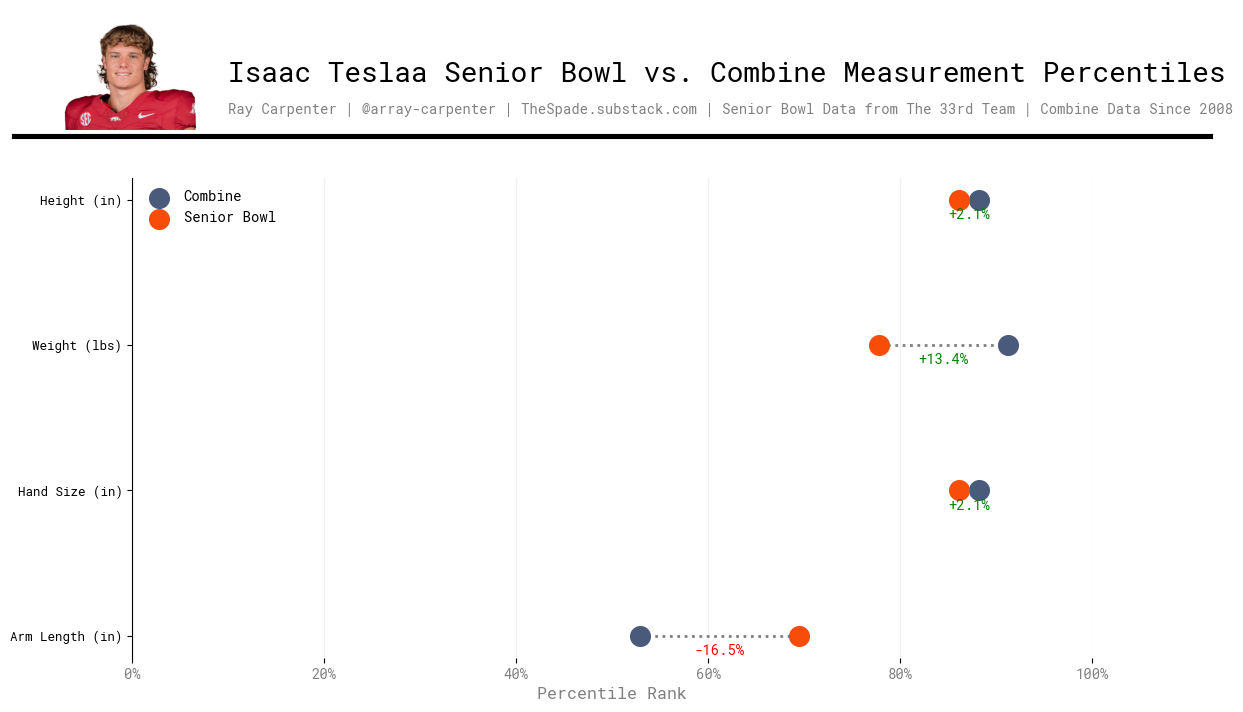

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import requests
from io import BytesIO
from PIL import Image
from matplotlib import font_manager

ROBOTO = font_manager.FontProperties(fname=r"nfl-draft-data\Roboto_Mono\RobotoMono-VariableFont_wght.ttf")

combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path)
senior_bowl_data = senior_bowl_data.dropna(subset=["athlete_id"])

merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

player_name = "Isaac Teslaa"
try:
    player_row = merged_data[merged_data["player"] == player_name].iloc[0]
except IndexError:
    raise ValueError(f"Player {player_name} not found in the merged dataset.")

player_pos = player_row["POS_GP"]
pos_group = merged_data[merged_data["POS_GP"] == player_pos]

measurement_cols = ["Height (in)", "Weight (lbs)", "Hand Size (in)", "Arm Length (in)"]

player_combine_percentiles = {}
player_senior_percentiles = {}

for col in measurement_cols:
    col_combine = col + "_combine"
    col_senior  = col + "_senior_bowl"
    
    values_combine = pos_group[col_combine].dropna().values
    values_senior  = pos_group[col_senior].dropna().values
    
    player_combine_val = player_row[col_combine]
    player_senior_val  = player_row[col_senior]
    
    combine_pct = rankdata(np.append(values_combine, player_combine_val), method="average")[-1] / (len(values_combine) + 1) * 100
    senior_pct  = rankdata(np.append(values_senior, player_senior_val), method="average")[-1] / (len(values_senior) + 1) * 100
    
    player_combine_percentiles[col] = combine_pct
    player_senior_percentiles[col]  = senior_pct

diff_percentiles = {col: player_combine_percentiles[col] - player_senior_percentiles[col] for col in measurement_cols}

plot_df = pd.DataFrame({
    "Measurement": measurement_cols,
    "Combine Percentile": [player_combine_percentiles[col] for col in measurement_cols],
    "Senior Bowl Percentile": [player_senior_percentiles[col] for col in measurement_cols],
    "Difference": [diff_percentiles[col] for col in measurement_cols]
})

print("Player's Percentile Rankings:")
print(plot_df)

def get_headshot_url(player: str, stats_df: pd.DataFrame) -> str:
    df_player = stats_df[stats_df["player"] == player]
    if df_player.empty:
        raise ValueError(f"No data found for player: {player}")
    if "athlete_id" not in df_player.columns:
        raise ValueError("The column 'athlete_id' is not present in the data.")
    athlete_id = int(df_player["athlete_id"].iloc[0])
    url = f"https://a.espncdn.com/combiner/i?img=/i/headshots/college-football/players/full/{athlete_id}.png?w=350&h=254"
    print("Headshot URL:", url)
    return url

try:
    headshot_url = get_headshot_url(player_name, combine_data)
    response = requests.get(headshot_url)
    if response.status_code == 200:
        player_image = Image.open(BytesIO(response.content))
    else:
        print(f"Failed to fetch headshot. HTTP Status Code: {response.status_code}")
        player_image = None
except Exception as e:
    print("Error fetching headshot:", e)
    player_image = None

fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor("white")

if player_image:
    player_img_ax = fig.add_axes([0.02, 0.76, 0.15, 0.15], frameon=False)
    player_img_ax.imshow(player_image)
    player_img_ax.set_xticks([])
    player_img_ax.set_yticks([])
else:
    print("No headshot available for the player.")

title_text = f"{player_name} Senior Bowl vs. Combine Measurement Percentiles"
fig.text(0.18, 0.82, title_text, fontsize=20, fontweight="bold", ha="left", fontproperties=ROBOTO)
fig.text(0.18, 0.78,
         "Ray Carpenter | @array-carpenter | TheSpade.substack.com | Senior Bowl Data from The 33rd Team | Combine Data Since 2008",
         fontsize=10, fontweight="bold", ha="left", color="gray", fontproperties=ROBOTO)

divider_ax = fig.add_axes([0, 0.75, 1, 0.005])
divider_ax.set_facecolor("black")
divider_ax.set_xticks([])
divider_ax.set_yticks([])

ax = fig.add_axes([0.1, 0.1, 0.8, 0.6])
ax.set_xlim(0, 100)

desired_order = ["Arm Length (in)","Hand Size (in)", "Weight (lbs)","Height (in)"]
plot_df["Measurement"] = pd.Categorical(plot_df["Measurement"], categories=desired_order, ordered=True)

plot_df = plot_df.sort_values("Measurement", ascending=False).reset_index(drop=True)
y_positions = np.arange(len(plot_df))

ax.hlines(y=y_positions,
          xmin=plot_df["Combine Percentile"],
          xmax=plot_df["Senior Bowl Percentile"],
          color='gray', linestyle=":", linewidth=2, zorder=1)

ax.scatter(plot_df["Combine Percentile"], y_positions, color='#4a5a7b', s=200, edgecolors='#4a5a7b', zorder=2, label='Combine')
ax.scatter(plot_df["Senior Bowl Percentile"], y_positions, color='#f84d08', s=200, edgecolors='#f84d08', zorder=2, label='Senior Bowl')

for pos, (_, row) in enumerate(plot_df.iterrows()):
    x_mid = (row["Combine Percentile"] + row["Senior Bowl Percentile"]) / 2
    diff = row["Difference"]
    if diff >= 0:
        sign = "+"
        ann_color = 'green'
    else:
        sign = "-"
        ann_color = 'red'
    ax.text(x_mid, y_positions[pos] + 0.15, f"{sign}{abs(diff):.1f}%", 
            ha="center", va="bottom", fontsize=10, color=ann_color, fontproperties=ROBOTO)

ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df["Measurement"], fontproperties=ROBOTO, fontsize=9, color="black")
ax.invert_yaxis() 

xticks = np.linspace(0, 100, 6)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{int(x)}%" for x in xticks], fontproperties=ROBOTO, fontsize=10, color="gray")
for xt in xticks:
    ax.axvline(xt, color="#f0f0f0", linewidth=1, zorder=0)

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.set_xlabel("Percentile Rank", fontproperties=ROBOTO, fontsize=12, color="gray")
ax.legend(frameon=False, prop=ROBOTO)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the CSV files
combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path)

senior_bowl_data = senior_bowl_data.dropna(subset=["athlete_id"])

merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

column = "Height (in)"
max_diff = 0
player_with_max_diff = None
result = None

for _, row in merged_data.iterrows():
    name = row["Name"]
    combine_value = row[f"{column}_combine"]
    senior_bowl_value = row[f"{column}_senior_bowl"]
    
    # Avoid division by zero
    if combine_value != 0 and senior_bowl_value != 0:
        percent_diff = (abs(combine_value - senior_bowl_value) / ((combine_value + senior_bowl_value) / 2)) * 100
        if percent_diff > max_diff:
            max_diff = percent_diff
            player_with_max_diff = name
            result = {
                "column": column,
                "combine_value": combine_value,
                "senior_bowl_value": senior_bowl_value,
                "percent_diff": percent_diff
            }

if player_with_max_diff is not None:
    print(f"Player with the biggest height difference: {player_with_max_diff}")
    print(f"Combine Height: {result['combine_value']}, Senior Bowl Height: {result['senior_bowl_value']}")
    print(f"Percentage Difference: {result['percent_diff']:.2f}%")
else:
    print("No valid data found for height differences.")


Player with the biggest height difference: Isaac Teslaa
Combine Height: 76.0, Senior Bowl Height: 74.875
Percentage Difference: 1.49%


In [ ]:
import pandas as pd

combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path)

senior_bowl_data = senior_bowl_data.dropna(subset=["athlete_id"])

merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

measurement_cols = ["Height (in)", "Weight (lbs)", "Hand Size (in)", "Arm Length (in)"]

top_differences = {}

for col in measurement_cols:
    col_combine = f"{col}_combine"
    col_senior  = f"{col}_senior_bowl"
    
    merged_data[f"{col}_percent_diff"] = merged_data.apply(
        lambda row: (abs(row[col_combine] - row[col_senior]) / ((row[col_combine] + row[col_senior]) / 2)) * 100 
                    if row[col_combine] != 0 and row[col_senior] != 0 else 0, axis=1
    )
    
    sorted_df = merged_data.sort_values(f"{col}_percent_diff", ascending=False)
    
    top_differences[col] = sorted_df[["Name", col_combine, col_senior, f"{col}_percent_diff"]].head(5)

for col, df in top_differences.items():
    print(f"Top differences for {col}:")
    print(df.to_string(index=False))
    print("-" * 50)


Top differences for Height (in):
            Name  Height (in)_combine  Height (in)_senior_bowl  Height (in)_percent_diff
    Isaac Teslaa                 76.0                   74.875                  1.491301
     Jaylin Lane                 70.0                   69.125                  1.257862
 Damien Martinez                 72.0                   71.125                  1.222707
Josh Conerly Jr.                 77.0                   76.125                  1.142857
  Brashard Smith                 70.0                   69.250                  1.077199
--------------------------------------------------
Top differences for Weight (lbs):
               Name  Weight (lbs)_combine  Weight (lbs)_senior_bowl  Weight (lbs)_percent_diff
Princely Umanmielen                 244.0                       264                   7.874016
     Mac McWilliams                 191.0                       181                   5.376344
     Shemar Stewart                 267.0                      

In [ ]:
import pandas as pd

# Load the CSV files
combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path)

senior_bowl_data = senior_bowl_data.dropna(subset=["athlete_id"])

merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

measurement_cols = ["Height (in)", "Weight (lbs)", "Hand Size (in)", "Arm Length (in)"]

avg_differences = {}

for col in measurement_cols:
    col_combine = f"{col}_combine"
    col_senior  = f"{col}_senior_bowl"
    
    merged_data[f"{col}_percent_diff"] = merged_data.apply(
        lambda row: (abs(row[col_combine] - row[col_senior]) / ((row[col_combine] + row[col_senior]) / 2)) * 100
                    if row[col_combine] != 0 and row[col_senior] != 0 else 0,
        axis=1
    )
    
    avg_diff = merged_data[f"{col}_percent_diff"].mean()
    avg_differences[col] = avg_diff

print("Average percentage differences by measurement category:")
for measurement, avg_diff in avg_differences.items():
    print(f"{measurement}: {avg_diff:.2f}%")

max_category = max(avg_differences, key=avg_differences.get)
print(f"\nThe measurement with the largest degree of difference is: {max_category} "
      f"with an average difference of {avg_differences[max_category]:.2f}%")

Average percentage differences by measurement category:
Height (in): 0.48%
Weight (lbs): 1.87%
Hand Size (in): 1.86%
Arm Length (in): 1.36%

The measurement with the largest degree of difference is: Weight (lbs) with an average difference of 1.87%


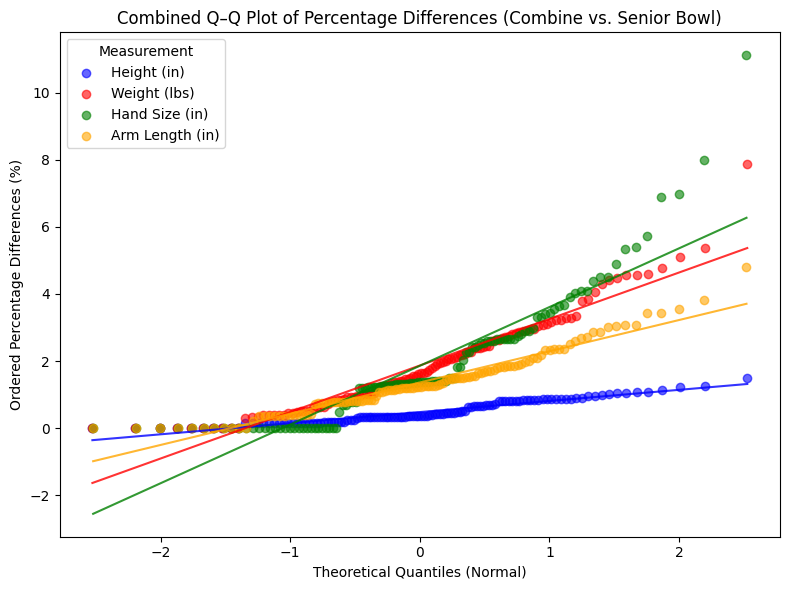

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

combine_data_path = r"nfl-draft-data\combine_data_unique_athlete_id_step4.csv"
senior_bowl_path = r"nfl-draft-data\senior_bowl_measurements_2025.csv"

combine_data = pd.read_csv(combine_data_path)
senior_bowl_data = pd.read_csv(senior_bowl_path).dropna(subset=["athlete_id"])
merged_data = pd.merge(combine_data, senior_bowl_data, on="athlete_id", suffixes=('_combine', '_senior_bowl'))

measurement_cols = ["Height (in)", "Weight (lbs)", "Hand Size (in)", "Arm Length (in)"]

pct_differences = {}

for col in measurement_cols:
    col_combine = f"{col}_combine"
    col_senior  = f"{col}_senior_bowl"
    
    pct_diff_series = merged_data.apply(
        lambda row: (
            abs(row[col_combine] - row[col_senior]) / ((row[col_combine] + row[col_senior]) / 2) * 100
        ) if row[col_combine] != 0 and row[col_senior] != 0 else np.nan,
        axis=1
    )
    pct_differences[col] = pct_diff_series.dropna()

fig, ax = plt.subplots(figsize=(8, 6))

colors = ["blue", "red", "green", "orange"]

for (col, color) in zip(measurement_cols, colors):
    data = pct_differences[col]
    
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm")
    
    ax.scatter(osm, osr, alpha=0.6, color=color, label=col)
    
    line_x = np.linspace(min(osm), max(osm), 100)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color=color, alpha=0.8)

ax.set_title("Combined Q–Q Plot of Percentage Differences (Combine vs. Senior Bowl)")
ax.set_xlabel("Theoretical Quantiles (Normal)")
ax.set_ylabel("Ordered Percentage Differences (%)")
ax.legend(title="Measurement", loc="best")

plt.tight_layout()
plt.show()
